In [79]:
#!pip install scipy

In [80]:
#Importamos los paquetes necesarios para el funcionamiento.
import csv
import tensorflow
tensorflow.config.run_functions_eagerly(False)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb
from tqdm import tqdm
import requests

In [81]:
#Usaremos colab para cargar los documentos de la tarea 1.
'''
from google.colab import drive

drive.mount('/content/gdrive')
'''

"\nfrom google.colab import drive\n\ndrive.mount('/content/gdrive')\n"

In [82]:
"""
Método add_feature1
Toma una matriz dispera x y agrega una o más características adicionales.
@param: dos matrices en formato csv.
@return: una matriz en formato csr.
"""
def add_feature1(X, feature_to_add):
    from scipy.sparse import csr_matrix, hstack
    # Se concatena la secuncia de caracteres del conjunto de train con un matriz dispersa
    return hstack([X, csr_matrix(feature_to_add)], 'csr')

"""
Método plot_graphs
Genera gráficos qeu muestra la evolución de métricas como pérdida o precisió, tanto en los datos de entrenamiento como de validación.
@param: history -> la historia del modelo, string -> el nombre de la métrica a graficar.
@return: Gráfico
"""
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [83]:
"""
Obtenemos los datos de entrenamiento y validación ya refinados.
"""
#Dataset roberta finetuned
train_roberta = pd.read_csv('/home/luiscamacho/Descargas/train_subtask1xlm-roberta-base-finetuned-IberAuTexTification2024-7030-4epo-task1-v2.csv', header=None)
test_roberta = pd.read_csv('/home/luiscamacho/Descargas/test_subtask1xlm-roberta-base-finetuned-IberAuTexTification2024-7030-4epo-task1-v2.csv', header=None)

#Dataset bert
train_bert = pd.read_csv('/home/luiscamacho/Descargas/train_subtask1bert-base-multilingual-cased-finetuned-autext24.csv', header=None)
test_bert = pd.read_csv('/home/luiscamacho/Descargas/test_subtask1bert-base-multilingual-cased-finetuned-autext24.csv', header=None)

#Dataset e5
train_e5 = pd.read_csv('/home/luiscamacho/Descargas/train_subtask1multilingual-e5-large-finetuned-autext24.csv', header=None)
test_e5 = pd.read_csv('/home/luiscamacho/Descargas/test_subtask1multilingual-e5-large-finetuned-autext24.csv', header=None)

#Dataset stylometry
train_stylometry = pd.read_csv('/home/luiscamacho/Descargas/stylometry_train_S1.csv')
test_stylometry = pd.read_csv('/home/luiscamacho/Descargas/stylometry_test_S1.csv')


In [84]:
#Dataset original
train_data = pd.read_csv('/home/luiscamacho/Descargas/train_S1.csv')
test_data = pd.read_csv('/home/luiscamacho/Descargas/test_S1.csv')

#Convertimos la columna "label" en etiquetas binarias, si el valor es "generated", le dará el valor de 1 o de lo contrario será 0.
train_data['label'] = np.where(train_data['label']=='generated',1,0)
test_data['label'] = np.where(test_data['label']=='generated',1,0)

#A la columna text del conjunto se le asignan las características independientes, mientras que a la columna "label" la etiqueta.
X_train_data = train_data['text']
y_train_data = train_data['label']

#A la columna text del conjunto se le asignan las características independientes, mientras que a la columna "label" la etiqueta.
X_test_data = test_data['text']
y_test_data = test_data['label']

#Mostramos las dimensiones (número de filas y columnas) de los datos de entrenamiento y de validación.
print(train_data.shape)
print(test_data.shape)

(76764, 3)
(32899, 3)


In [85]:
#Datos de entrenamiento
#Unimos todas las características para el entrenamiento en un solo objeto.
X_train_data = add_feature1(train_stylometry, train_bert)
X_train_data = add_feature1(X_train_data, train_e5)
X_train_data = add_feature1(X_train_data, train_roberta)

#Datos de prueba
#Unimos todas las características oara la validación en un solo objeto.
X_test_data = add_feature1(test_roberta, test_bert)
X_test_data = add_feature1(X_test_data, test_e5)
X_test_data = add_feature1(X_test_data, test_stylometry)

In [86]:
#Volvemos a mostrar las dimensiones de las características viendo que coincidan en el número de filas
print(X_train_data.shape)
print(y_train_data.shape)

(76764, 2573)
(76764,)


In [87]:
"""
Comenzamos el procseo de la Red Neuronal simple.
Con la primera capa densa conectada con 128 neuronas y la segundo con 64 con la función ReLu que introduce la no linealiedad, además que X_train_data.shape[1] defina las entradas en la red.
El primer y segundo dropout que desactiva el 20% de las neuronas para prevenir el sobreajuste.
Finalmente con una capa de salida con la función sigmoid debido a que estamos haciendo una clasificación binaria.
"""
model = tensorflow.keras.Sequential([
    tensorflow.keras.layers.Dense(128, activation='relu', input_shape = (X_train_data.shape[1],)),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Dense(64, activation='relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Dense(1, activation='sigmoid')
])

"""
Creamos el optimizador Adam con un learning rate de 0.001 que es lo que controla el tamali de los pasos que toma durante la actualización.
"""
learning_rate = 0.001
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)

"""
Compilamos el modelo con la función de pérdida binary_crossentropy, el optimizador Adam y la métrica de precisión, que mide el rendimiento del modelo.
"""
model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
model.summary() #Mostramos el modelo

/home/luiscamacho/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       329,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,793 (1.29 MB)

 Trainable params: 337,793 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
"""
Se entrena el modelo con los datos proporcionados, donde history almacena el historial del entrenamiento.
@X_train_data: Datos de entrada.
@y_train_data: Datos de salida correpondientes a X_train_data.
@epochs: El número de veces que el modelo pasrá por el conjunto, entre más mejor.
@batch_size: Define el tamaño en el que los datos se dividirán para el entrenamiento.
@validation_split: Define la fracción de los datos de entrenamiento que se utilizarán para la validación.
"""
history = model.fit(X_train_data, y_train_data, epochs=5, batch_size=128, validation_split=0.3)

Epoch 1/5
420/420 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9908 - loss: 0.0199 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 2/5
420/420 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9997 - val_loss: 8.7116e-04
Epoch 3/5
420/420 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9997 - val_loss: 0.0010
Epoch 4/5
420/420 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9998 - val_loss: 7.7199e-04
Epoch 5/5
420/420 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9993 - val_loss: 0.0023


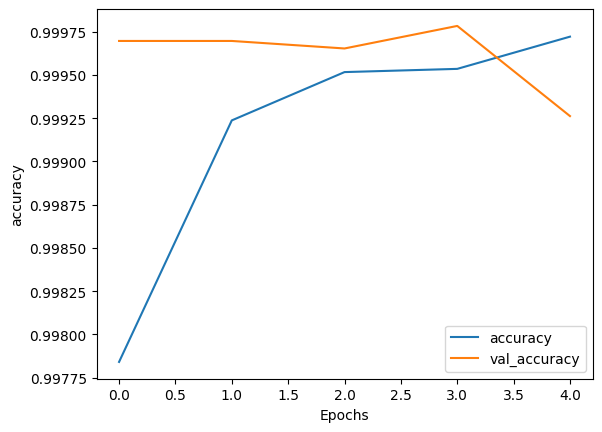

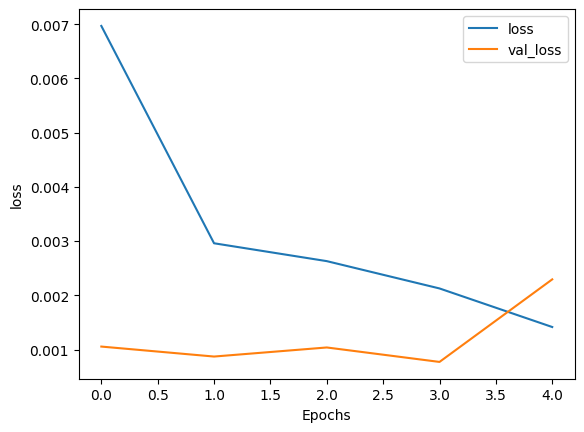

In [89]:
"""
Usamos el método anteriormente creado.
Donde accurcay represneta la precisión de los datos de entrenamiento.
Y val_accuracy representa la precisión de los datos de validación.
"""
plot_graphs(history,"accuracy")
plot_graphs(history, "loss")

In [90]:
#Evaluación, checamos para saber la precisión del modelo que se medirá en una probabbilidad de 0 a 1.
test_loss,test_acc = model.evaluate(X_test_data, y_test_data)
print('Test Accuracy: ', test_acc)

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9482 - loss: 0.4599
Test Accuracy:  0.9459254145622253
